## Lectura fitxer

In [56]:
import pandas as pd

df = pd.read_csv("datasets/Data Carrard.csv")
df = df.drop('id', axis = 1)

In [57]:
df['target'] = df['stai_t'] + df['cesd']
df = df.drop(['stai_t', 'cesd'], axis=1)

In [58]:
X = df.drop('target', axis=1)
y = df['target']

## Aplicació model

### Utilització de totes les característiques

Fent 2 agrupacions per determinar si necessiten o no assistència médica

In [59]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [60]:
n_clusters = 2  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = model_sc.fit_predict(X)

In [61]:
df_clustered = X.copy() 
df_clustered['cluster'] = clusters 
df_clustered.head(5) 

,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,mbi_ex,mbi_cy,mbi_ea,cluster
0,18,1,1,120,1,0,56,3,0,88,62,27,17,0.738095,17,13,20,1
1,26,4,1,1,1,0,20,4,0,109,55,37,22,0.690476,14,11,26,0
2,21,3,2,1,0,0,36,3,0,106,64,39,17,0.690476,24,7,23,0
3,21,2,2,1,0,1,51,5,0,101,52,33,18,0.833333,16,10,21,0
4,21,3,1,1,1,0,22,4,0,102,58,28,21,0.690476,22,14,23,0


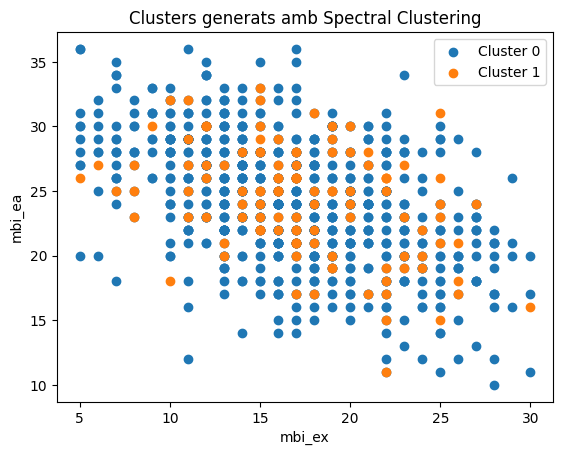

In [62]:
# Plot dels punts amb diferents colors segons el cluster al qual pertanyen
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points.iloc[:, 14], cluster_points.iloc[:, 16], label=f'Cluster {i}')

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('mbi_ea')
plt.legend()
plt.show()

In [63]:
# Grouping the data frame by cluster to get the properties of each cluster
cluster_grouped = df_clustered.groupby('cluster')
cluster_properties = cluster_grouped.mean()

# Printing the properties of each cluster (mean values of the variables)
print(cluster_properties)

               age      year       sex      glang      part       job  \
cluster                                                                 
0        22.359638  3.169470  1.694696   2.241915  0.573092  0.360931   
1        22.548673  2.646018  1.699115  97.000000  0.495575  0.265487   

            stud_h    health      psyt        jspe   qcae_cog   qcae_aff  \
cluster                                                                    
0        24.936611  3.783959  0.231565  106.712807  58.703752  34.971539   
1        27.699115  3.734513  0.176991  104.061947  57.309735  33.504425   

              amsp  erec_mean     mbi_ex     mbi_cy     mbi_ea  
cluster                                                         
0        23.241915   0.723064  16.813713  10.024580  24.209573  
1        22.522124   0.700169  17.318584  10.451327  24.194690  


In [64]:
# Getting the number of patients in each cluster
cluster_grouped.size()

cluster
0    773
1    113
dtype: int64

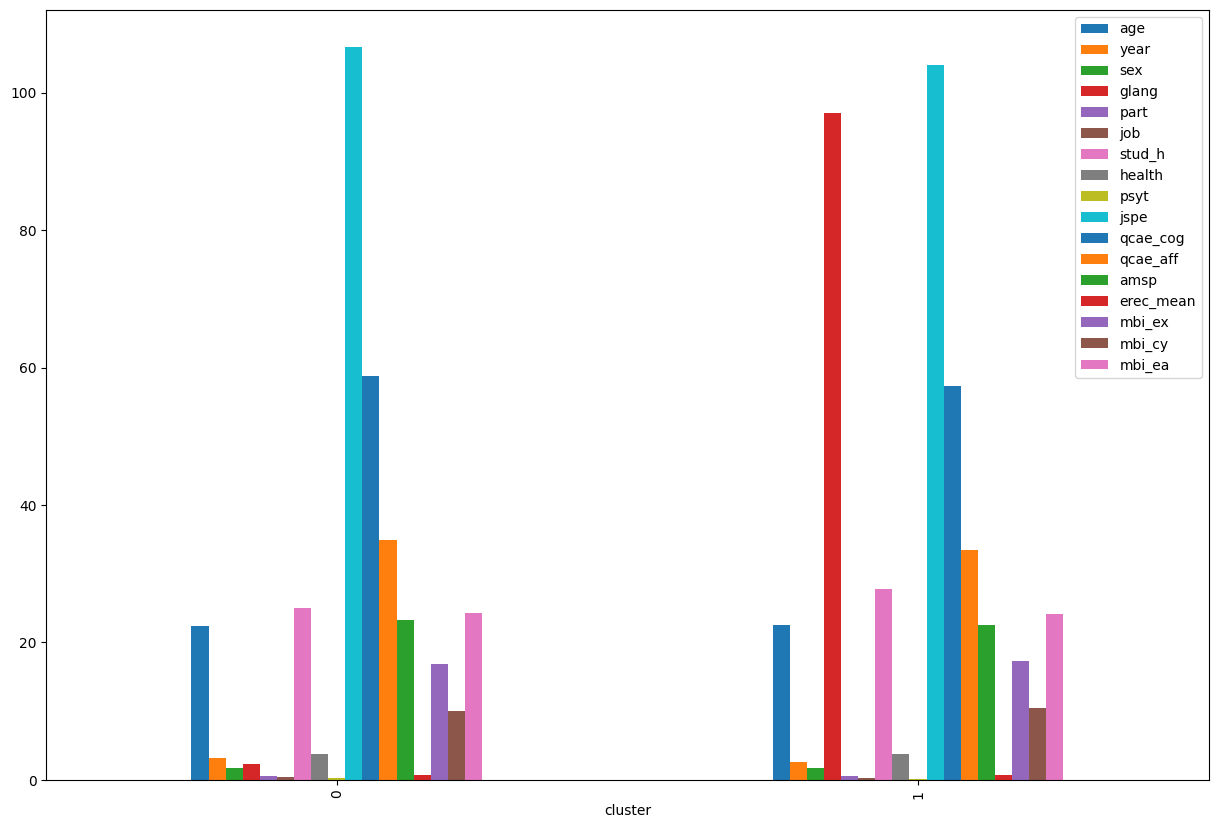

In [65]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

Com podem observar als resultats dels valors mitjans i de la gràfica, no podem concloure cap conclusió clara. Veiem que la columna que més varia d'una gràfica a una altra és la que pertany a la variable glang. Aquesta variable indica la llengua dels estudiants cosa que no considerem significativa.

## Avaluació Model

Definim un threshold per determinar a partir de quin punt considerem que la persona en qüestió pateix una enfermetat mental (ansietat o depressió). Tenint en compte que la nostra y=cesd+stai_t, és a dir la suma de escala de depressió i ansietat. Linterval d'aquestes dues és el següent:

* cesd: 0 - 56
* stai_t: 20 - 77

In [66]:
threshold = (56+77)*0.6
threshold

79.8

In [67]:
#Fem Dataset per avaluar el model 
df_aval = df_clustered.copy() 
df_aval['target'] = y
df_aval

,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,mbi_ex,mbi_cy,mbi_ea,cluster,target
0,18,1,1,120,1,0,56,3,0,88,62,27,17,0.738095,17,13,20,1,95
1,26,4,1,1,1,0,20,4,0,109,55,37,22,0.690476,14,11,26,0,40
2,21,3,2,1,0,0,36,3,0,106,64,39,17,0.690476,24,7,23,0,98
3,21,2,2,1,0,1,51,5,0,101,52,33,18,0.833333,16,10,21,0,65
4,21,3,1,1,1,0,22,4,0,102,58,28,21,0.690476,22,14,23,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,21,2,1,1,1,0,45,3,0,106,63,39,28,0.619048,23,4,34,0,80
882,20,2,2,1,0,0,13,3,0,113,67,40,21,0.809524,17,5,24,0,67
883,19,1,1,1,0,0,50,5,0,100,50,31,24,0.547619,15,8,31,0,59
884,24,5,2,1,0,0,20,2,1,120,64,39,21,0.785714,22,15,19,0,91


In [68]:
# Filtrem les files amb 'target' superior a threshold
df_target_gt_threshold = df_aval[df_aval['target'] > threshold]

# Fem el recompte agrupant per 'cluster'
count_by_cluster = df_target_gt_threshold.groupby('cluster').size()

# Mostrem el resultat
print("Recompte estudiants que necessiten ajuda\n", count_by_cluster)

Recompte estudiants que necessiten ajuda
 cluster
0    151
1     28
dtype: int64


In [69]:
total_cluster = cluster_grouped.size()
total_cluster
print("\nRecompte estudiants totals en cluster\n", total_cluster)


Recompte estudiants totals en cluster
 cluster
0    773
1    113
dtype: int64


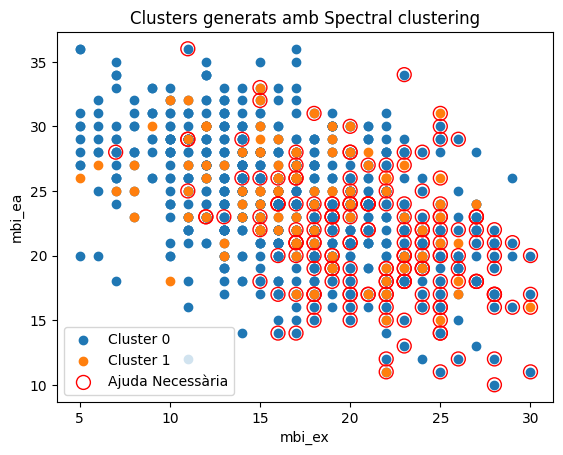

In [70]:
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['mbi_ea'], label=f'Cluster {i}')

# Plot dels punts que superen el llindar amb marques diferents (per exemple, cercles buits)
plt.scatter(df_target_gt_threshold['mbi_ex'], df_target_gt_threshold['mbi_ea'], label='Ajuda Necessària', facecolors='none', edgecolors='r', marker='o', s=100)

plt.title('Clusters generats amb Spectral clustering')
plt.xlabel('mbi_ex')
plt.ylabel('mbi_ea')
plt.legend()
plt.show()

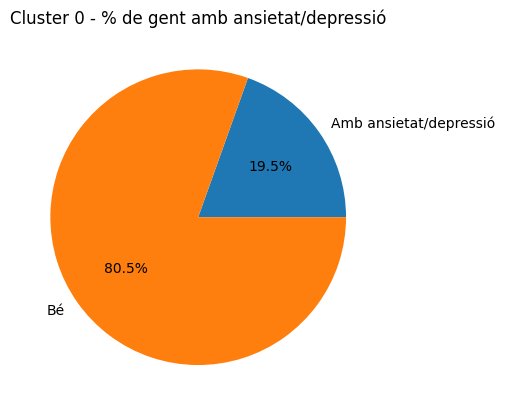

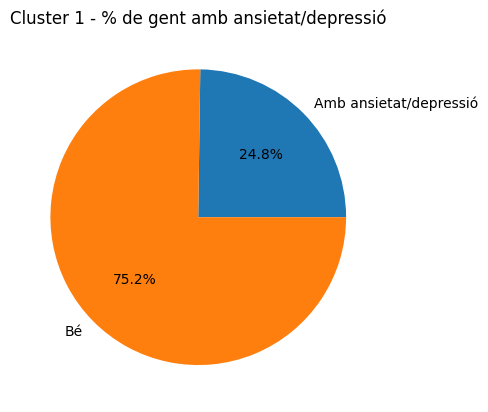

In [71]:
labels = 'Amb ansietat/depressió', 'Bé'
dades = []
for c in range(n_clusters):
    resta = total_cluster[c] - count_by_cluster[c]
    dades.append([count_by_cluster[c], resta])

for i, d in enumerate(dades):
    fig, ax = plt.subplots()
    ax.pie(d, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Cluster {i} - % de gent amb ansietat/depressió')
    plt.show()

**Conclusions**

Considerant que el cluster 1 és el que hauria de tenir estudiants amb ansietat/depressió i veient els diagrames. Observem que el clúster 1 té un resultat bastant semblant de casos de depressió/ansietat al clúster 0. Llavors, com podem observar, podem assegurar que no estem obtenint una bona agrupació.

### Utilització de les característiques més rellevants

Fent 2 agrupacions per determinar si necessiten o no assistència médica

#### Random forest

Recordem que els coeficients amb Random Forest dels diferents atributs eren:

|    | atribut   | importancia |
|----|-----------|-------------|
| 9  | jspe      | 0.086444    |
| 10 | qcae_cog  | 0.084919    |
| 6  | stud_h    | 0.084754    |
| 11 | qcae_aff  | 0.082221    |
| 14 | mbi_ex    | 0.079569    |
| 12 | amsp      | 0.079371    |
| 13 | erec_mean | 0.078246    |
| 16 | mbi_ea    | 0.078138    |
| 15 | mbi_cy    | 0.073213    |
| 0  | age       | 0.067432    |
| 1  | year      | 0.048998    |
| 7  | health    | 0.041126    |
| 3  | glang     | 0.027404    |
| 4  | part      | 0.026077    |
| 5  | job       | 0.022708    |
| 2  | sex       | 0.021316    |
| 8  | psyt      | 0.018066    |

Per fer aquesta part ens quedarem els atributs que tenen l'importància major a **0.060000**

In [72]:
import pandas as pd

df = pd.read_csv("datasets/Data Carrard.csv")
df = df.drop('id', axis = 1)
df['target'] = df['stai_t'] + df['cesd']
df = df.drop(['stai_t', 'cesd'], axis=1)
X = df.drop('target', axis=1)
y = df['target']

In [73]:
# X Random Forest
X_rf = X[['jspe', 'qcae_cog', 'stud_h', 'qcae_aff', 'mbi_ex', 'amsp', 'erec_mean', 'mbi_ea', 'mbi_cy', 'age']]

In [74]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

In [75]:
n_clusters = 2  # Ajustar el número deseado de clusters
model_sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = model_sc.fit_predict(X_rf)

In [76]:
df_clustered = X_rf.copy() 
df_clustered['cluster'] = clusters 
df_clustered.head(5) 

,jspe,qcae_cog,stud_h,qcae_aff,mbi_ex,amsp,erec_mean,mbi_ea,mbi_cy,age,cluster
0,88,62,56,27,17,17,0.738095,20,13,18,1
1,109,55,20,37,14,22,0.690476,26,11,26,0
2,106,64,36,39,24,17,0.690476,23,7,21,1
3,101,52,51,33,16,18,0.833333,21,10,21,1
4,102,58,22,28,22,21,0.690476,23,14,21,0


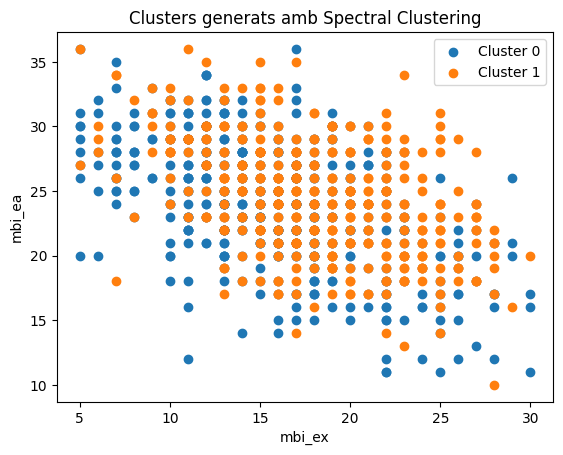

In [55]:
# Plot dels punts amb diferents colors segons el cluster al qual pertanyen
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['mbi_ea'], label=f'Cluster {i}')

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('mbi_ea')
plt.legend()
plt.show()

In [77]:
# Grouping the data frame by cluster to get the properties of each cluster
cluster_grouped = df_clustered.groupby('cluster')
cluster_properties = cluster_grouped.mean()

# Printing the properties of each cluster (mean values of the variables)
print(cluster_properties)

               jspe   qcae_cog     stud_h   qcae_aff     mbi_ex       amsp  \
cluster                                                                      
0        107.852008  58.714588  12.871036  34.997886  15.873150  23.192389   
1        104.682809  58.309927  39.510896  34.539952  18.029056  23.101695   

         erec_mean     mbi_ea     mbi_cy        age  
cluster                                              
0          0.72536  24.023256  10.376321  23.302326  
1          0.71417  24.418886   9.738499  21.331719  


In [78]:
# Getting the number of patients in each cluster
total_cluster = cluster_grouped.size()
total_cluster

cluster
0    473
1    413
dtype: int64

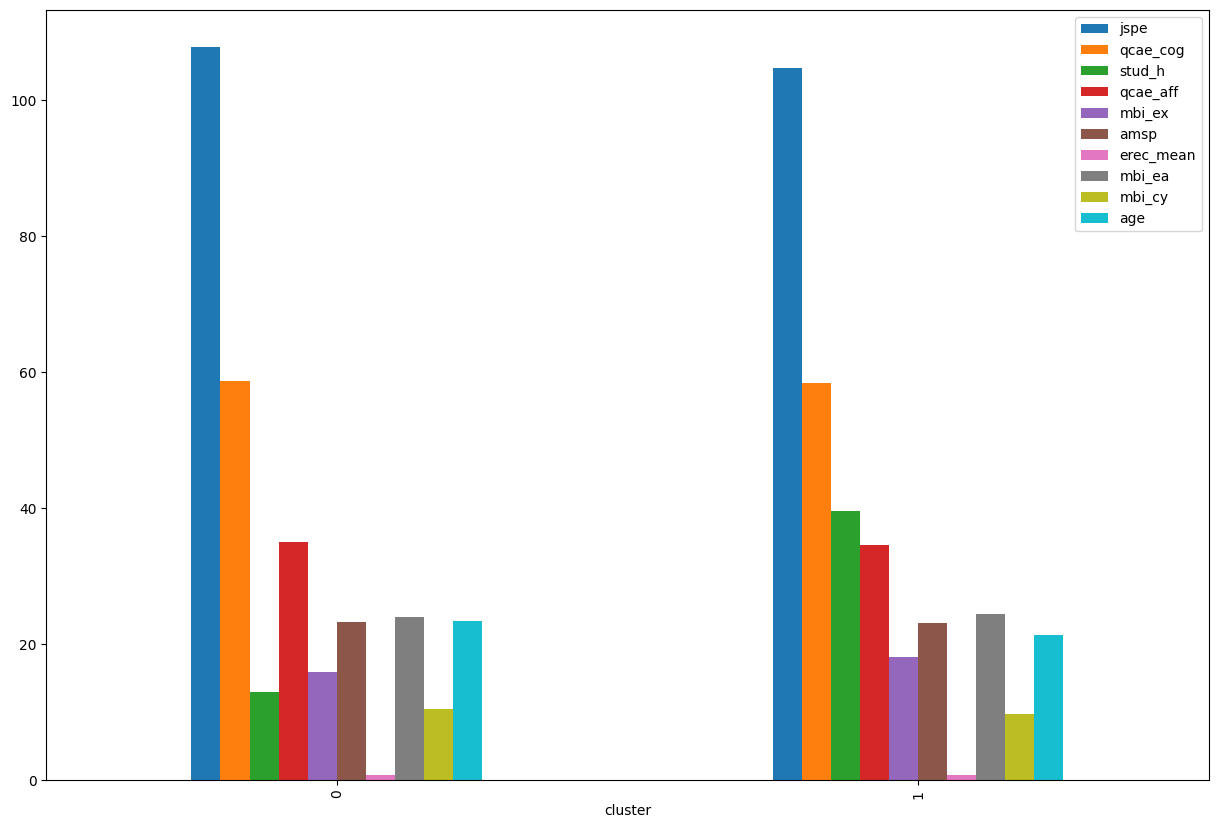

In [79]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

### Avaluació Model

In [80]:
cesd_max = 56
stai_t_max = 77
threshold = (cesd_max+stai_t_max)*0.6
threshold

79.8

In [81]:
#Fem Dataset per avaluar el model 
df_aval = df_clustered.copy() 
df_aval['target'] = y
df_aval

,jspe,qcae_cog,stud_h,qcae_aff,mbi_ex,amsp,erec_mean,mbi_ea,mbi_cy,age,cluster,target
0,88,62,56,27,17,17,0.738095,20,13,18,1,95
1,109,55,20,37,14,22,0.690476,26,11,26,0,40
2,106,64,36,39,24,17,0.690476,23,7,21,1,98
3,101,52,51,33,16,18,0.833333,21,10,21,1,65
4,102,58,22,28,22,21,0.690476,23,14,21,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...
881,106,63,45,39,23,28,0.619048,34,4,21,1,80
882,113,67,13,40,17,21,0.809524,24,5,20,0,67
883,100,50,50,31,15,24,0.547619,31,8,19,1,59
884,120,64,20,39,22,21,0.785714,19,15,24,0,91


In [82]:
# Filtrem les files amb 'target' superior a threshold
df_target_gt_threshold = df_aval[df_aval['target'] > threshold]

# Fem el recompte agrupant per 'cluster'
count_by_cluster = df_target_gt_threshold.groupby('cluster').size()

# Mostrem el resultat
print("Recompte estudiants que necessiten ajuda\n", count_by_cluster)

print("\nRecompte estudiants totals en cluster\n", total_cluster)

Recompte estudiants que necessiten ajuda
 cluster
0     72
1    107
dtype: int64

Recompte estudiants totals en cluster
 cluster
0    473
1    413
dtype: int64


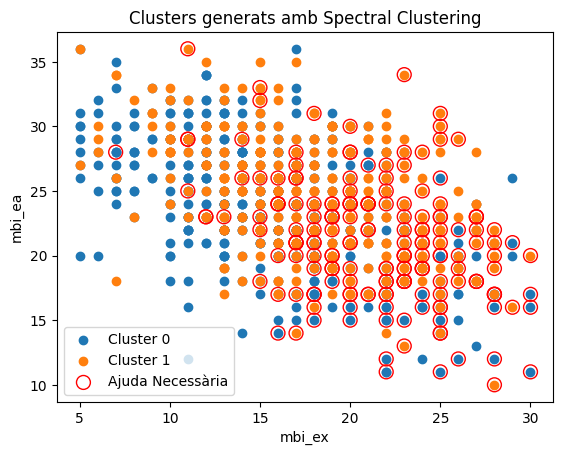

In [83]:
for i in range(n_clusters):
    cluster_points = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(cluster_points['mbi_ex'], cluster_points['mbi_ea'], label=f'Cluster {i}')

# Plot dels punts que superen el llindar amb marques diferents (per exemple, cercles buits)
plt.scatter(df_target_gt_threshold['mbi_ex'], df_target_gt_threshold['mbi_ea'], label='Ajuda Necessària', facecolors='none', edgecolors='r', marker='o', s=100)

plt.title('Clusters generats amb Spectral Clustering')
plt.xlabel('mbi_ex')
plt.ylabel('mbi_ea')
plt.legend()
plt.show()

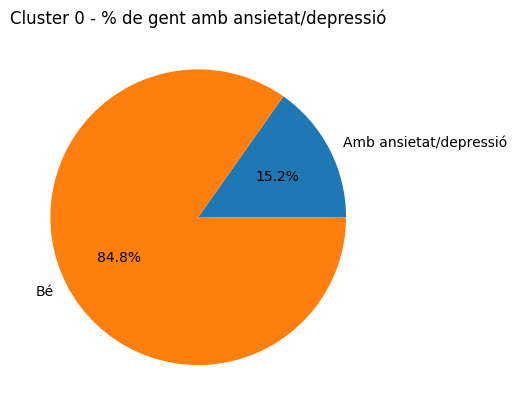

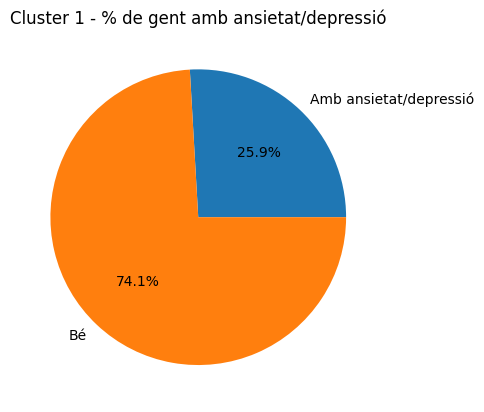

In [84]:
labels = 'Amb ansietat/depressió', 'Bé'
dades = []
for c in range(n_grups):
    resta = total_cluster[c] - count_by_cluster[c]
    dades.append([count_by_cluster[c], resta])

for i, d in enumerate(dades):
    fig, ax = plt.subplots()
    ax.pie(d, labels=labels, autopct='%1.1f%%')
    ax.set_title(f'Cluster {i} - % de gent amb ansietat/depressió')
    plt.show()

**Conclusions**

Quan hem utilitzat totes les característiques hem presuposat que el cluster 1 és el que hauria de tenir els estudiants amb necessitat d'ajuda psicològica. Recordem que teníem:
* Cluster 0: 19.5%
* Cluster 1: 24.8%

Ara un cop reduïdes les característiques gràcies a Random Forest, les agrupacions obtingudes tenen una mica més de diferència pel que fa el percentatge de gent amb ansietat/depressió:
* Cluster 0: 15.2%
* Cluster 1: 25.9%

Notem que reduint les característiques hem obtingut una millora pel que fa l'agrupació. Així, tornem a reduir el nombre de caracterísitques.